# Image Search with Vector Databases

## 1. Getting Semantic Vectors
We´re going to obtain a semantic vector from an image

In [1]:
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_experimental.open_clip import OpenCLIPEmbeddings
import glob
import base64

Initiate the OpenCLIPEmbeddings embedding model

In [2]:
embedding_model = OpenCLIPEmbeddings(
    model_name="ViT-B-32",  # Correct format
    checkpoint="openai",
    device="cpu"
)

Retrieve Image File Paths

In [3]:
# The glob.glob function retrieves all .jpeg images in the ../images/ directory
paths = glob.glob('./images_data/*.jpeg', recursive=True)

print("Total Images:", len(paths))

Total Images: 10


## 2. Storing Image Vectors
Store image vectors in a FAISS vector database using OpenCLIP embeddings

### Encode Images in Base64
Since LLMs cannot process raw images, we convert each image into a base64-encoded string.


The encode_image function:

⦁	Opens the image file

⦁	Reads the image as bytes

⦁	Encodes it into a UTF-8 base64 string

In [4]:
def encode_image(path):
    with open(path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

### Convert Images into Documents
We iterate over all image paths and create a LangChain Document for each:

⦁	page_content → Stores the base64-encoded image.

⦁	metadata → Stores the original image file path.


In [5]:
lc_docs = []

for path in paths:
    doc = Document(
        page_content=encode_image(path),
        metadata={
            'source': path
        }
    )
    lc_docs.append(doc)


### Store Documents in FAISS
Now that we have our documents, we store them in a FAISS vector database. We use OpenCLIPEmbeddings to generate the embeddings.


In [6]:
vector_store = FAISS.from_documents(lc_docs, embedding=embedding_model)

print("FAISS vector store created.")
print("FAISS index size:", vector_store.index.ntotal)

FAISS vector store created.
FAISS index size: 10


### Convert FAISS into a Retriever
Turn the FAISS vector store into a retriever to enable similarity search:


In [7]:
retriever = vector_store.as_retriever()
print("Retriever initialized successfully.")

Retriever initialized successfully.


### Retrieve Similar Images
Pass an encoded image to the retriever and fetch the top 4 most similar images to cat_1.


In [9]:
docs = retriever.invoke(encode_image("./images_data/cat_1.jpeg"), k=4) 


### Display Results
To verify the retrieved images, we print their file paths:


In [10]:
for doc in docs:
    print(doc.metadata)

{'source': './images_data/cat_1.jpeg'}
{'source': './images_data/cat_2.jpeg'}
{'source': './images_data/cat_4.jpeg'}
{'source': './images_data/cat_5.jpeg'}


✔ The first result is cat_1 itself.

✔ The following results are cat_2, cat_4, and cat_5, indicating high similarity.

## Finding the Dog Most Similar to a Cat
The goal is to determine which dog image is the most similar to cats, based on our image embedding model.

### Concept Behind the Approach
The basic idea is:

⦁	Find the dog image that retrieves the most cat images when queried.

⦁	Weight results inversely by rank (higher-ranked cat results contribute more).

⦁	Compare all dogs and assign them a "cat similarity score."


### Solution Overview

⦁	Retrieve all dog image paths.

⦁	For each dog image, retrieve its most similar images.

⦁	Count how many of the retrieved images are cats.

⦁	Assign an inverse-weighted score based on ranking.

⦁	Determine the dog with the highest "cat similarity score."


### Retrieve all dog image paths

In [11]:
dog_paths = glob.glob('./images_data/dog*.jpeg', recursive=True)

### Find and Score Each Dog
⦁	Loop through all dog images.

⦁	Retrieve the top matches for each dog.

⦁	Count how many cat images appear in the top results.

⦁	Assign an inverse-weighted score (higher-ranked cats contribute more).


In [14]:
dog_to_cat = {}

for dog_pic in dog_paths:
    docs = retriever.invoke(encode_image(dog_pic))  # Retrieve similar images
    cats_retrieved = 0
    
    for i, doc in enumerate(docs):
        if "cat" in doc.metadata["source"]:  # Check if the retrieved image is a cat
            cats_retrieved += 4 - i  # Inverse-weighting based on rank

    dog_to_cat[dog_pic] = cats_retrieved  # Store results

### Display Results
The final dictionary dog_to_cat stores the similarity score for each dog image:

In [13]:
dog_to_cat

{'./images_data/dog_3.jpeg': 1,
 './images_data/dog_4.jpeg': 1,
 './images_data/dog_5.jpeg': 2,
 './images_data/dog_1.jpeg': 0,
 './images_data/dog_2.jpeg': 1}

This suggests that the OpenCLIP embeddings effectively differentiate between dog and cat images.

- dog_5.jpeg has the highest score (2), meaning it retrieved more cat images than the other dog images.

- This might indicate that dog_5.jpeg shares some visual features with cat images (e.g., posture, lighting, color, background).

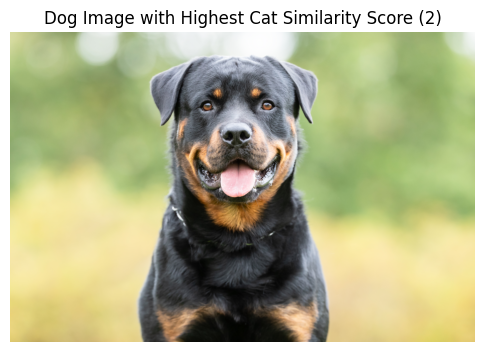

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

# Find the dog image with the highest score
best_dog_image = max(dog_to_cat, key=dog_to_cat.get)
highest_score = dog_to_cat[best_dog_image]

# Load and display the image
image = Image.open(best_dog_image)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Dog Image with Highest Cat Similarity Score ({highest_score})")
plt.show()


### Conclusion: 
- The OpenCLIP model seems to be performing well in distinguishing dog images from cat images, as most retrievals favor the same class.

- Some images (like dog_5.jpeg) may contain overlapping features between the two classes, leading to minor misclassifications in similarity search.

- If the goal is strict classification, further fine-tuning of the embedding model or additional preprocessing (e.g., image augmentation or feature engineering) may help improve separation between classes.